This notebook is an example on how to fine tune mT5 model with Higgingface Transformers to solve multilingual task in 101 lanaguges. This notebook especially takes the problem of question generation in hindi lanagues

In [1]:
!pip install pytorch_lightning==0.8.1

     |████████████████████████████████| 293 kB 2.1 MB/s eta 0:00:01
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 1.0.6
    Uninstalling pytorch-lightning-1.0.6:
      Successfully uninstalled pytorch-lightning-1.0.6
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
!pip install transformers==4.0.0rc1

     |████████████████████████████████| 1.3 MB 2.2 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 54.6 MB/s eta 0:00:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.9.2
    Uninstalling tokenizers-0.9.2:
      Successfully uninstalled tokenizers-0.9.2
  Attempting uninstall: transformers
    Found existing installation: transformers 3.4.0
    Uninstalling transformers-3.4.0:
      Successfully uninstalled transformers-3.4.0
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

allennlp 1.2.1 requires transformers<3.5,>=3.1, but you'll have transformers 4.0.0rc1 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
class Config():
    #paths
    df_root='../input/xquad'
    output_dir="/kaggle/working/result"

    
    #hyperparameters
    max_seq_length=100
    learning_rate=3e-4
    weight_decay=0.0
    adam_epsilon=1e-8
    warmup_steps=0
    train_batch_size=8
    eval_batch_size=8
    num_train_epochs=20
    gradient_accumulation_steps=8
    n_gpu=1
    fp_16=False # if you want to enable 16-bit training then install apex and set this to true
    opt_level='O1'
    max_grad_norm=1.0
    
    #model type
    model_type="small" # choices small, base, large, xl,xxl

In [4]:
config=Config()

In [5]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from transformers import AdamW, AutoTokenizer, MT5ForConditionalGeneration, get_linear_schedule_with_warmup
import transformers

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Initialize model
8


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: Checkpoint directory /kaggle/working/result exists and is not empty with save_top_k != 0.All files in this directory will be deleted when a checkpoint is saved!
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


 Training model



  | Name  | Type                        | Params
------------------------------------------------------
0 | model | MT5ForConditionalGeneration | 300 M 
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.



training finished
Saving model
Saved model
Losses Saved


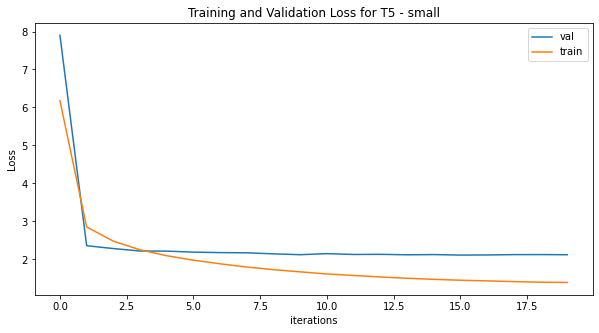

In [18]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from transformers import AdamW, AutoTokenizer, MT5ForConditionalGeneration, get_linear_schedule_with_warmup
import transformers


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

my_losses=[]

def get_dataset(tokenizer, type_path, args):
    return QuestionDataset(tokenizer=tokenizer, data_dir=args.data_dir, type_path=type_path,  max_len=args.max_seq_length)

class T5FineTuner(pl.LightningModule):
    def __init__(self, hparams):
        global my_losses
        my_losses.append("start")
        super(T5FineTuner, self).__init__()
        self.hparams = hparams
        
        self.my_logs=[]
        print(self.hparams.train_batch_size)

        self.model = MT5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
        self.tokenizer = AutoTokenizer.from_pretrained(hparams.tokenizer_name_or_path)

    def is_logger(self):
        return True

    def forward(
            self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, labels=None
    ):
        return self.model(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            labels=labels,
        )

    def _step(self, batch):
        labels = batch["target_ids"]
        labels[labels[:, :] == self.tokenizer.pad_token_id] = -100

        outputs = self(
            input_ids=batch["source_ids"],
            attention_mask=batch["source_mask"],
            labels=labels,
            decoder_attention_mask=batch['target_mask']
        )

        loss = outputs[0]

        return loss

    def training_step(self, batch, batch_idx):
        loss = self._step(batch)

        tensorboard_logs = {"train_loss": loss}
        
        return {"loss": loss, "log": tensorboard_logs}

    def training_epoch_end(self, outputs):
        global my_losses
        avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
        tensorboard_logs = {"avg_train_loss": avg_train_loss}
        my_losses.append({"avg_train_loss": avg_train_loss})
        return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        loss = self._step(batch)
        return {"val_loss": loss}

    def validation_epoch_end(self, outputs):
        global my_losses
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        tensorboard_logs = {"val_loss": avg_loss}
        my_losses.append({"avg_val_loss": avg_loss})
        return {"avg_val_loss": avg_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

    def configure_optimizers(self):

        model = self.model
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.hparams.weight_decay,
            },
            {
                "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
        self.opt = optimizer
        return [optimizer]

    def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None):
        if self.trainer.use_tpu:
            xm.optimizer_step(optimizer)
        else:
            optimizer.step()
        optimizer.zero_grad()
        self.lr_scheduler.step()

    def get_tqdm_dict(self):
        tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

        return tqdm_dict

    def train_dataloader(self):
        train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="train", args=self.hparams)
        dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True,
                                num_workers=4)
        t_total = (
                (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
                // self.hparams.gradient_accumulation_steps
                * float(self.hparams.num_train_epochs)
        )
        scheduler = get_linear_schedule_with_warmup(
            self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
        )
        self.lr_scheduler = scheduler
        return dataloader

    def val_dataloader(self):
        val_dataset = get_dataset(tokenizer=self.tokenizer, type_path="valid", args=self.hparams)
        return DataLoader(val_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)

logger = logging.getLogger(__name__)

class LoggingCallback(pl.Callback):
        def __init__(self):
            super(LoggingCallback, self).__init__()
            self.logs_info=[]
            
        
        def on_validation_end(self, trainer, pl_module):
            logger.info("***** Validation results *****")
            if pl_module.is_logger():
                  metrics = trainer.callback_metrics
                  # Log results
                  for key in sorted(metrics):
                    if key not in ["log", "progress_bar"]:
                      logger.info("{} = {}\n".format(key, str(metrics[key])))

        def on_test_end(self, trainer, pl_module):
            logger.info("***** Test results *****")
            self.logs_info.append(trainer.callback_metrics)
            if pl_module.is_logger():
                metrics = trainer.callback_metrics

                  # Log and save results to file
                output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
                with open(output_test_results_file, "w") as writer:
                    for key in sorted(metrics):
                          if key not in ["log", "progress_bar"]:
                            logger.info("{} = {}\n".format(key, str(metrics[key])))
                            writer.write("{} = {}\n".format(key, str(metrics[key])))
                            
args_dict = dict(
    data_dir=config.df_root, # path for data files
    output_dir=config.output_dir, # path to save the checkpoints
    model_name_or_path='google/mt5-{}'.format(config.model_type),
    tokenizer_name_or_path='google/mt5-{}'.format(config.model_type),
    max_seq_length=config.max_seq_length,
    learning_rate=config.learning_rate,
    weight_decay=config.weight_decay,
    adam_epsilon=config.adam_epsilon,
    warmup_steps=config.warmup_steps,
    train_batch_size=config.train_batch_size,
    eval_batch_size=config.eval_batch_size,
    num_train_epochs=config.num_train_epochs,
    gradient_accumulation_steps=config.gradient_accumulation_steps,
    n_gpu=config.n_gpu,
    fp_16=config.fp_16, # if you want to enable 16-bit training then install apex and set this to true
    opt_level=config.opt_level, # you can find out more on optimisation levels here https://nvidia.github.io/apex/amp.html#opt-levels-and-properties
    max_grad_norm=config.max_grad_norm, # if you enable 16-bit training then set this to a sensible value, 0.5 is a good default
    seed=42
)

class QuestionDataset(Dataset):
    def __init__(self, tokenizer, data_dir, type_path, max_len=30):
        self.path = os.path.join(data_dir, type_path + '.csv')

        self.english = 'context'
        self.turkissh = 'question'
        self.data = pd.read_csv(self.path)
        path_val=self.path.split(".")[-2][-1]

        self.max_len = max_len
        self.tokenizer = tokenizer
        self.inputs = []
        self.targets = []

        self._build()

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        source_ids = self.inputs[index]["input_ids"].squeeze()
        target_ids = self.targets[index]["input_ids"].squeeze()

        src_mask = self.inputs[index]["attention_mask"].squeeze()  # might need to squeeze
        target_mask = self.targets[index]["attention_mask"].squeeze()  # might need to squeeze

        return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}

    def _build(self):
        for idx in range(len(self.data)):
            input_text,output_text= self.data.loc[idx, self.english],self.data.loc[idx, self.turkissh]
   
            input_ = "Turkish Context: %s" % (input_text)
            target = "%s " %(output_text)

            # tokenize inputs
            tokenized_inputs = self.tokenizer.batch_encode_plus(
                [input_], max_length=200, pad_to_max_length=True, return_tensors="pt"
            )
            # tokenize targets
            tokenized_targets = self.tokenizer.batch_encode_plus(
                [target], max_length=20, pad_to_max_length=True, return_tensors="pt"
            )

            self.inputs.append(tokenized_inputs)
            self.targets.append(tokenized_targets)

args = argparse.Namespace(**args_dict)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    period =1,filepath=args.output_dir, prefix="checkpoint", monitor="val_loss", mode="min", save_top_k=1
)
callback_history=LoggingCallback()
train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    precision= 16 if args.fp_16 else 32,
    amp_level=args.opt_level,
    gradient_clip_val=args.max_grad_norm,
    checkpoint_callback=checkpoint_callback,
    callbacks=[callback_history],
)
print ("Initialize model")
model = T5FineTuner(args)
trainer = pl.Trainer(**train_params)

print (" Training model")
history = trainer.fit(model)

print ("training finished")

print ("Saving model")
model.model.save_pretrained("/kaggle/working/result")

print ("Saved model")


my_losses.pop(0)
my_losses.pop(1)
val_loss=[]
train_loss=[]
for i in range(len(my_losses)):
    if(i%2==0):
        val_loss.append(float(my_losses[i]['avg_val_loss']))
    else:
        train_loss.append(float(my_losses[i]['avg_train_loss']))
        
        
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss for T5 - {}".format(config.model_type))
plt.plot(val_loss,label="val")
plt.plot(train_loss,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("Training and Validation Loss for T5 - {}.png".format(config.model_type))
print("Losses Saved")

In [19]:
!pip install -U nltk

Requirement already up-to-date: nltk in /opt/conda/lib/python3.7/site-packages (3.8)
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [20]:
!pip install rouge_score

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [21]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
class SCORESS():
    def BLUE_SCORE(self,output,references,n_gram=4):
        if(n_gram==4):
            weight=[0,0,0,1]
        if(n_gram==3):
            weight=[0,0,1,0]
        if(n_gram==2):
            weight=[0,1,0,0]
        if(n_gram==1):
            weight=[1,0,0,0]
        max_score=-1
        for qt_q in references:
            reference = [qt_q.split()]
            bleu_score=sentence_bleu(reference, output.split(),weights=weight)
            max_score=max(bleu_score,max_score)
        return max_score

    def ROUGE_SCORE(self,output,references):
        scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
        max_score_1=-1
        max_score_l=-1
        for qt_q in references:
            scores = scorer.score(qt_q,output)
            scores['rouge1'].fmeasure
            scores['rougeL'].fmeasure
            max_score_1=max(scores['rouge1'].fmeasure,max_score_1)
            max_score_l=max(scores['rougeL'].fmeasure,max_score_l)     

        return max_score_1, max_score_l

    def METEOR_SCORE(self,output,references):
        max_score=-1
        for qt_q in references:
            reference = [qt_q.split()]
            my_score=meteor_score(reference, output.split())
            max_score=max(my_score,max_score)
        return max_score

In [22]:
calculate_score=SCORESS()

In [23]:
tr=pd.read_csv(config.df_root+"/train.csv")
vl=pd.read_csv(config.df_root+"/valid.csv")
from transformers import MT5ForConditionalGeneration, AutoTokenizer
model = MT5ForConditionalGeneration.from_pretrained(config.output_dir)
tokenizer = AutoTokenizer.from_pretrained("google/mt5-base")


In [24]:
def greedy_decoding (inp_ids,attn_mask):
    greedy_output = model.generate(input_ids=inp_ids, attention_mask=attn_mask, max_length=256)
    Question =  tokenizer.decode(greedy_output[0], skip_special_tokens=True,clean_up_tokenization_spaces=True)
    return Question.strip().capitalize()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
context_q=dict()
i=0
j=0
while (i<len(vl)-2):
    curr_context=vl["context"][i]
    context_q["Turkish Context: "+curr_context]=[]
    for j in range(i,len(vl)):
        if(curr_context==vl["context"][j]):
            context_q["Turkish Context: "+curr_context].append(vl["question"][j])
        else:    
            i=j
            break

In [25]:
from nltk.translate.bleu_score import sentence_bleu
blue_score=0
rouge_L_score=0
rouge_1_score=0
meteor_scoree=0
counter=0
for article in context_q.keys():
    encoding = tokenizer.encode_plus(article, return_tensors="pt")
    input_ids, attention_masks = encoding["input_ids"].to(device), encoding["attention_mask"].to(device)
    max_score=0
    output = greedy_decoding(input_ids,attention_masks)
    blue_score+=calculate_score.BLUE_SCORE(output,context_q[article])
    rouge1,rougeL=calculate_score.ROUGE_SCORE(output,context_q[article])
    rouge_L_score+=rougeL
    rouge_1_score+=rouge1
    meteor_scoree+=calculate_score.METEOR_SCORE(output,context_q[article])
        
    counter+=1

In [26]:
print("Blue-4 Score",blue_score/counter)
print("Rouge-L Score",rouge_L_score/counter)
print("Rouge-1 Score",rouge_1_score/counter)
print("Meteor Score",meteor_scoree/counter)

Blue-4 Score 0.6199210375270077
Rouge-L Score 0.3912524624868167
Rouge-1 Score 0.40554353233102347
Meteor Score 0.259094532434502


In [6]:
tokenizer = AutoTokenizer.from_pretrained('google/mt5-large')

In [31]:
input_ = "Turkish Context: %s" % ("İstanbul, Türkiye'nin kalbinde yer alan bir şehir ve aynı zamanda ülkenin en büyük şehridir. İstanbul, Doğu ve Batı kültürlerinin birleştiği bir noktadır ve bu yüzden tarihi ve kültürel değeri olan birçok yer barındırmaktadır. İstanbul, Haliç'te yer alan Boğaziçi Köprüsü ile Avrupa ve Asya kıtaları arasında bir bağ oluşturur. İstanbul ayrıca İstanbul Boğazı ve Marmara Denizi ile çevrili olup, bu nedenle deniz taşımacılığı açısından da önemlidir. İstanbul, İstanbul Üniversitesi gibi ünlü üniversitelerinin de bulunduğu bir eğitim merkezidir.")

In [32]:
encoded=tokenizer.batch_encode_plus([input_], max_length=200, pad_to_max_length=True, return_tensors="pt")

In [33]:
encoded

{'input_ids': tensor([[   259,  60583,    259,  59315,    267,  17412,    261,   9275,    277,
           1785,  31471,   8238,   4344,  18463,    698,    259,  23028,    529,
           1099,  10946,   4808,    407,    259,  17229,   1785,    289,  12533,
          43870,    286,   6900,    260,  17412,    261,    259, 105339,    529,
            364,  30045,    408,  48058,  13012, 215627,  62002,    698,  39057,
          11211,    529,    758,  12448,    880,    259,  60486,    529,    408,
          48058,    701,  41962,    266,   3143,    698,   3803,   4344,   2373,
         130400,  18202,    260,  17412,    261,  42456,    993,    277,    346,
           4344,  18463,   3417,  98343, 139474,  43091,    286,  42145,   2222,
            259,  39249,    529, 127499,    262,    259,  16779,    422,   1954,
            259,    262,  10699,    698,  67946, 158111,    286,    260,  17412,
          26073,    750,  17412,   3417,   8910,  23216,    529,  95871,    262,
          8271

In [34]:
print(tokenizer.decode(encoded['input_ids'][0]))

Turkish Context: İstanbul, Türkiye'nin kalbinde yer alan bir şehir ve aynı zamanda ülkenin en büyük şehridir. İstanbul, Doğu ve Batı kültürlerinin birleştiği bir noktadır ve bu yüzden tarihi ve kültürel değeri olan birçok yer barındırmaktadır. İstanbul, Haliç'te yer alan Boğaziçi Köprüsü ile Avrupa ve Asya kıtaları arasında bir bağ oluşturur. İstanbul ayrıca İstanbul Boğazı ve Marmara Denizi ile çevrili olup, bu nedenle deniz taşımacılığı açısından da önemlidir. İstanbul, İstanbul Üniversitesi gibi ünlü üniversitelerinin de bulunduğu bir eğitim merkezidir.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
